In [8]:
from sqlalchemy.orm import relationship, sessionmaker
from sqlalchemy import create_engine
from database import Reactions

engine = create_engine('sqlite:///reactions2.db', echo = False)

Session = sessionmaker(bind=engine)
session = Session()

In [9]:
def getRxnFP(r, fp_type, summed, multipliers):
    if fp_type == "MACCS":
        rxnMatrix = np.zeros((5,167))
    else:
        rxnMatrix = np.zeros((5,2048))
    row = 0
    for k,m in zip(reagent_classes,multipliers):
        sm = getattr(r,k)
        if sm == "NONE":
            fp = np.zeros((1,))
        else:
            if k == "solvent":
                mol = Chem.MolFromSmiles(solv_map[sm])
                if fp_type == "MACCS":
                    DataStructs.ConvertToNumpyArray(MACCSkeys.GenMACCSKeys(mol), fp)
                else:
                    DataStructs.ConvertToNumpyArray(AllChem.GetMorganFingerprintAsBitVect(mol, 4), fp)
                if "%" in sm:
                    s2 = sm.split("_")[1]
                    mol2 = Chem.MolFromSmiles(solv_map[s2])
                    fp2 = np.zeros((1,))
                    if fp_type == "MACCS":
                        DataStructs.ConvertToNumpyArray(MACCSkeys.GenMACCSKeys(mol), fp2)
                    else:
                        DataStructs.ConvertToNumpyArray(AllChem.GetMorganFingerprintAsBitVect(mol, 4), fp2)

                    fp = np.add(fp,fp2)
            else:
                mol = Chem.MolFromSmiles(sm)
                fp = np.zeros((1,))
                if fp_type == "MACCS":
                    DataStructs.ConvertToNumpyArray(MACCSkeys.GenMACCSKeys(mol), fp)
                else:
                    DataStructs.ConvertToNumpyArray(AllChem.GetMorganFingerprintAsBitVect(mol, 4), fp)
        fp = fp*m
        rxnMatrix[row,:] = fp
        row = row + 1
    if summed:
        return np.sum(rxnMatrix, axis=0)
    else:
        return rxnMatrix

In [10]:
r = session.query(Reactions).all()
import numpy as np
from rdkit import Chem
from rdkit.Chem import DataStructs, AllChem, MACCSkeys
import pandas as pd

reagent_classes = ["electrophile", "nucleophile", "catalyst_smiles", "base_smiles", "solvent"]
solv_map = {"NMP":'O=C1N(C)CCC1', "DMSO":'O=S(C)C',"DMF":'O=CN(C)C', \
            "25%H2O_NMP":'[H]O[H].O=C1N(C)CCC1', "25%H2O_DMSO":'O=S(C)C.[H]O[H]', "25%H2O_DMF":'O=CN(C)C.[H]O[H]', \
            "25%tAmOH_DMSO":"CCC(C)(O)C.O=S(C)C","10%tAmOH_NMP":"CCC(C)(O)C.O=C1N(C)CCC1"}

multipliers = [1, 1, 1, 1, 1]
rxnfps = []
yields = []
data = {k:[] for k in reagent_classes}
smiles_to_name = {}
smiles_to_yields = {}
for k in r:
    if "Suzuki" not in k.reaction_name:
        continue
    fp = getRxnFP(k, "MFP4", True, multipliers)
    rxnfps.append(fp)
    n = k.group
    if n == "0":
        yields.append(0)
    elif n == "low":
        yields.append(1)
    elif n == "med":
        yields.append(2)
    else:
        yields.append(3)
    for i,j in enumerate(reagent_classes):
        data[j].append(getattr(k,j))
        if j == "catalyst_smiles":
            smiles_to_name[getattr(k,j)] = k.catalyst
            if getattr(k,j) not in smiles_to_yields:
                smiles_to_yields[getattr(k,j)] = []
            # smiles_to_yields[getattr(k,j)].append(k.
        if j == "base_smiles":
            smiles_to_name[getattr(k,j)] = k.base
print(len(rxnfps), len(yields))

/var/folders/8k/w__0g4xs7rj0xv7hk3dqm71w0000gn/T/ipykernel_13993/2897161779.py:1: SAWarning: Dialect sqlite+pysqlite does *not* support Decimal objects natively, and SQLAlchemy must convert from floating point - rounding errors and other issues may occur. Please consider storing Decimal numbers as strings or integers on this platform for lossless storage.
  r = session.query(Reactions).all()


2786 2786


In [11]:
multipliers = [1, 1, 1, 1, 3]
rxnfps_solvent_3 = []
types = []
for k in r:
    if "Suzuki" not in k.reaction_name:
        continue
    fp = getRxnFP(k, "MFP4", True, multipliers)
    types.append(k.solvent)
    rxnfps_solvent_3.append(fp)
print(len(rxnfps_solvent_3), len(yields))

2786 2786


In [12]:
from sklearn.manifold import TSNE

X_TSNE_RFP_SOLVENT_3 = TSNE(n_components=2, n_jobs=-1, perplexity=15).fit_transform(rxnfps_solvent_3)

/opt/homebrew/Caskroom/miniforge/base/envs/sklearn-env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/sklearn-env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [14]:
data["x_solvent"] = []
data["y_solvent"] = []
for k in X_TSNE_RFP_SOLVENT_3[:,0]:
    data["x_solvent"].append(k) 
for k in X_TSNE_RFP_SOLVENT_3[:,1]:
    data["y_solvent"].append(k)
for k in reagent_classes:
    print(len(data[k]))
print(len(data["x_solvent"]))
print(len(data["y_solvent"]))
df_solvent = pd.DataFrame(data)

2786
2786
2786
2786
2786
2786
2786


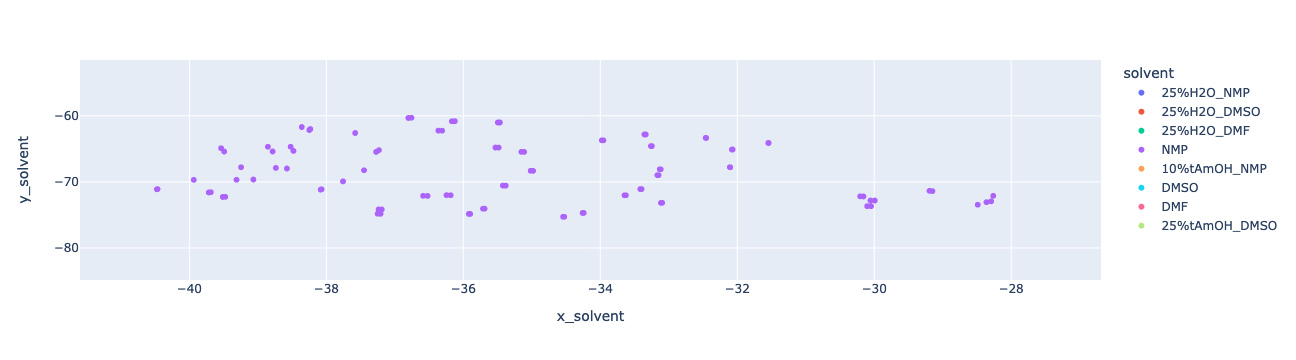

In [71]:
import plotly.express as px
fig = px.scatter(df_solvent, x="x_solvent", y="y_solvent", hover_data=['catalyst_smiles', 'electrophile', 'nucleophile', 'base_smiles', 'solvent'], color='solvent')
fig.show()

In [15]:
i = 0
cluster_sets = {k:[] for k in reagent_classes}
yields_cluster = []
for x,y in zip(df_solvent["x_solvent"], df_solvent["y_solvent"]):
    if x < -58 and x > -74 and y < -35 and y > -60:
        # print(x,y)
        for k in reagent_classes:
            # print(k, df[k][i])
            if df_solvent[k][i] not in cluster_sets[k]:
                cluster_sets[k].append(df_solvent[k][i])
        yields_cluster.append(yields[i])
    i = i + 1
print(np.mean(yields_cluster))
for k in cluster_sets:
    print(k, len(cluster_sets[k]))
    if k == "catalyst_smiles" or k == "base_smiles":
        for j in cluster_sets[k]:
            print(j, smiles_to_name[j])
    else:
        for j in cluster_sets[k]:
            print(j)            

2.725
electrophile 1
COC(=O)[C@@H]1C[C@H](CN1C(=O)OCc2ccccc2)OC(=O)N3Cc4cccc(Br)c4C3
nucleophile 10
CN(C)c1ccc(cc1)B2OC(C)(C)C(C)(C)O2
Cc1cc(O)ccc1B2OC(C)(C)C(C)(C)O2
OB(O)c1ccc(cc1)C(=O)NC2CCCC2
CC1(C)OB(OC1(C)C)c2cccc(c2)C3(CC3)NC(=O)OCc4ccccc4
CC1(C)OB(OC1(C)C)c2ccc(cc2)c3cnccn3
OB(O)c1cccnc1
CC1(C)OB(OC1(C)C)c2cnc(nc2)n3cccn3
CC1(C)OB(OC1(C)C)c2cnn(Cc3ccccc3)c2
CC1(C)OB(OC1(C)C)c2cn(c3ncccc23)S(=O)(=O)c4ccccc4
CC1(C)OB(OC1(C)C)C2=CCCCC2
catalyst_smiles 2
[Pd](OS(=O)(=O)C)c1c(c2c(N)cccc2)cccc1.P(C(C)(C)C)(C(C)(C)C)c1ccc(N(C)C)cc1 APhos Pd G3
CC(C)(C)P(C(C)(C)C)C(C)(C)C.Cl[Pd]c1ccccc1c2ccccc2N tBu3P Pd G2
base_smiles 2
CC(C)(C)N=[P](N1CCCC1)(N2CCCC2)N3CCCC3 BTTP
CN(C)C(N(C)C)=NC(C)(C)C BTMG
solvent 1
25%tAmOH_DMSO


In [16]:
for k in df['electrophile']:
    if 'Brc1cc' in k:
        print(k)

NameError: name 'df' is not defined

In [13]:
type_list = []
for k in types:
    # print(k)
    if k not in type_list:
        type_list.append(k)
types_one_hot = [type_list.index(k) for k in df["solvent"]]
for k in type_list:
    print(k)

NameError: name 'df' is not defined

NameError: name 'types_one_hot' is not defined

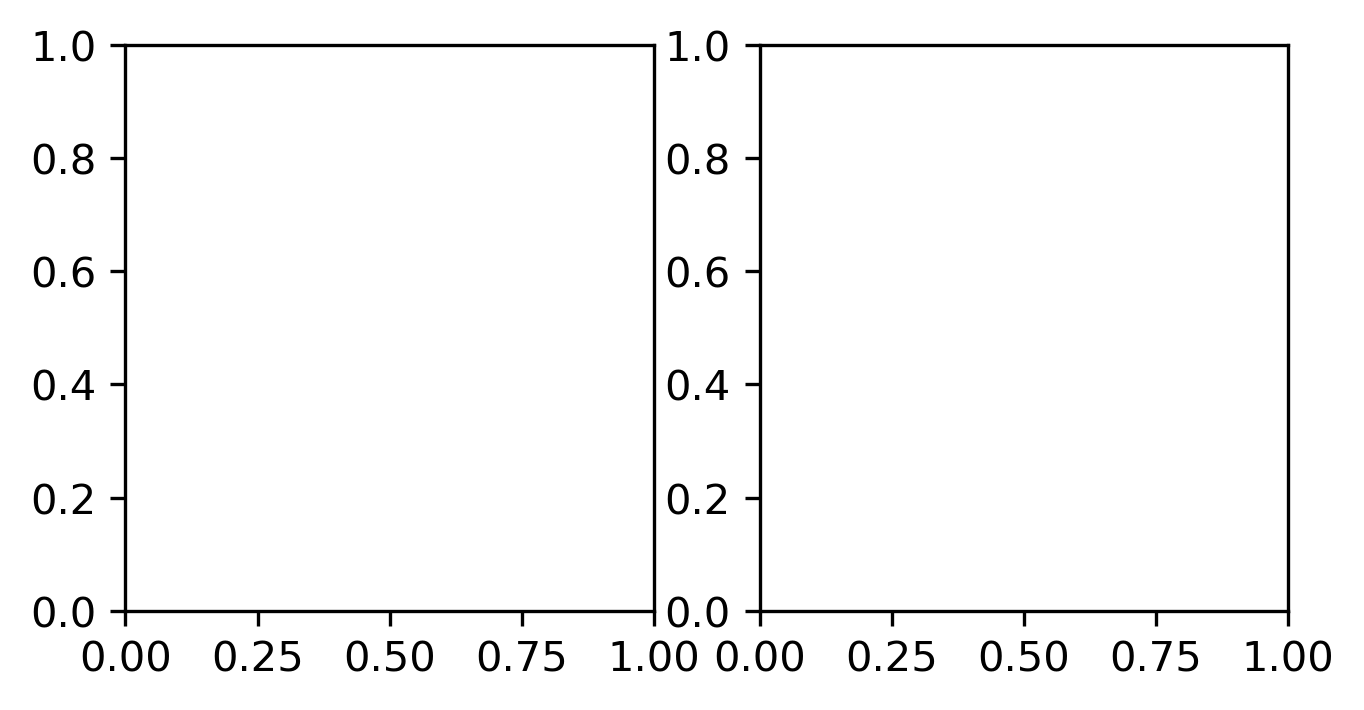

In [17]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2,figsize=(5,2.5), dpi=300)

ax[0].scatter(X_TSNE_RFP_SOLVENT_3[:,0], X_TSNE_RFP_SOLVENT_3[:,1], cmap='inferno', c=types_one_hot, alpha=.5, marker='.',s=15)
ax[1].scatter(X_TSNE_RFP_SOLVENT_3[:,0], X_TSNE_RFP_SOLVENT_3[:,1], cmap='viridis', c=yields, alpha=.5, marker='.',s=15)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
# ax[0].legend()
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('figure2tsne.png', dpi=300, bbox_inches='tight')

In [41]:
multipliers = [1, 1, 3, 1, 1]
rxnfps_cat_3 = []
types = []
for k in r:
    if "Suzuki" not in k.reaction_name:
        continue
    fp = getRxnFP(k, "MFP4", True, multipliers)
    types.append(k.catalyst_smiles)
    rxnfps_cat_3.append(fp)
print(len(rxnfps_cat_3), len(yields))

2786 2786


In [34]:
from sklearn.manifold import TSNE

X_TSNE_RFP_CAT_3 = TSNE(n_components=2, n_jobs=-1, perplexity=15).fit_transform(rxnfps_cat_3)

/opt/homebrew/Caskroom/miniforge/base/envs/sklearn-env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/opt/homebrew/Caskroom/miniforge/base/envs/sklearn-env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [35]:
data["x"] = []
data["y"] = []
for k in X_TSNE_RFP_CAT_3[:,0]:
    data["x"].append(k) 
for k in X_TSNE_RFP_CAT_3[:,1]:
    data["y"].append(k)
for k in reagent_classes:
    print(len(data[k]))
print(len(data["x"]))
print(len(data["y"]))
df = pd.DataFrame(data)

2786
2786
2786
2786
2786
2786
2786


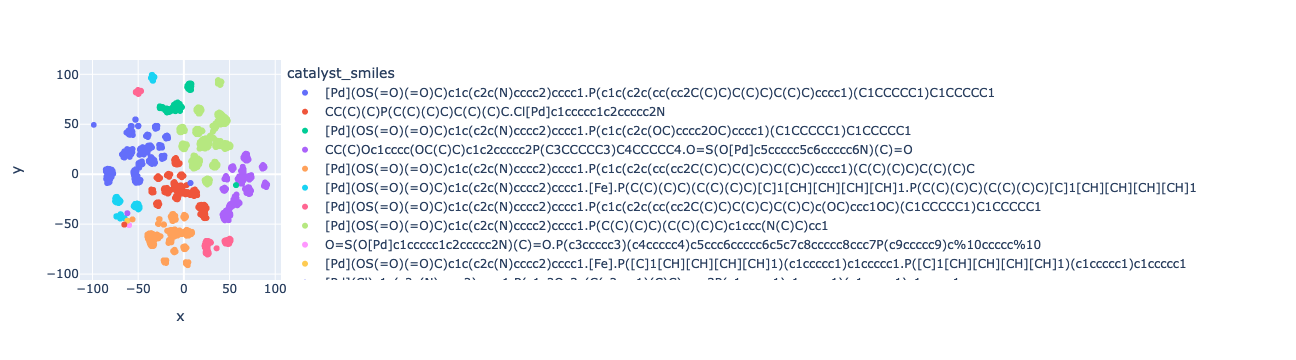

In [44]:
import plotly.express as px
fig = px.scatter(df, x="x", y="y", hover_data=['catalyst_smiles', 'electrophile', 'nucleophile', 'base_smiles', 'solvent'], color='catalyst_smiles')
fig.show()

In [42]:
type_list = []
for k in types:
    if k not in type_list:
        type_list.append(k)
types_one_hot = [type_list.index(k) for k in df["catalyst_smiles"]]
for k in type_list:
    print(k)

[Pd](OS(=O)(=O)C)c1c(c2c(N)cccc2)cccc1.P(c1c(c2c(cc(cc2C(C)C)C(C)C)C(C)C)cccc1)(C1CCCCC1)C1CCCCC1
CC(C)(C)P(C(C)(C)C)C(C)(C)C.Cl[Pd]c1ccccc1c2ccccc2N
[Pd](OS(=O)(=O)C)c1c(c2c(N)cccc2)cccc1.P(c1c(c2c(OC)cccc2OC)cccc1)(C1CCCCC1)C1CCCCC1
CC(C)Oc1cccc(OC(C)C)c1c2ccccc2P(C3CCCCC3)C4CCCCC4.O=S(O[Pd]c5ccccc5c6ccccc6N)(C)=O
[Pd](OS(=O)(=O)C)c1c(c2c(N)cccc2)cccc1.P(c1c(c2c(cc(cc2C(C)C)C(C)C)C(C)C)cccc1)(C(C)(C)C)C(C)(C)C
[Pd](OS(=O)(=O)C)c1c(c2c(N)cccc2)cccc1.[Fe].P(C(C)(C)C)(C(C)(C)C)[C]1[CH][CH][CH][CH]1.P(C(C)(C)C)(C(C)(C)C)[C]1[CH][CH][CH][CH]1
[Pd](OS(=O)(=O)C)c1c(c2c(N)cccc2)cccc1.P(c1c(c2c(cc(cc2C(C)C)C(C)C)C(C)C)c(OC)ccc1OC)(C1CCCCC1)C1CCCCC1
[Pd](OS(=O)(=O)C)c1c(c2c(N)cccc2)cccc1.P(C(C)(C)C)(C(C)(C)C)c1ccc(N(C)C)cc1
O=S(O[Pd]c1ccccc1c2ccccc2N)(C)=O.P(c3ccccc3)(c4ccccc4)c5ccc6ccccc6c5c7c8ccccc8ccc7P(c9ccccc9)c%10ccccc%10
[Pd](OS(=O)(=O)C)c1c(c2c(N)cccc2)cccc1.[Fe].P([C]1[CH][CH][CH][CH]1)(c1ccccc1)c1ccccc1.P([C]1[CH][CH][CH][CH]1)(c1ccccc1)c1ccccc1
[Pd](Cl)c1c(c2c(N)cccc2)cccc1.P(c1c2Oc

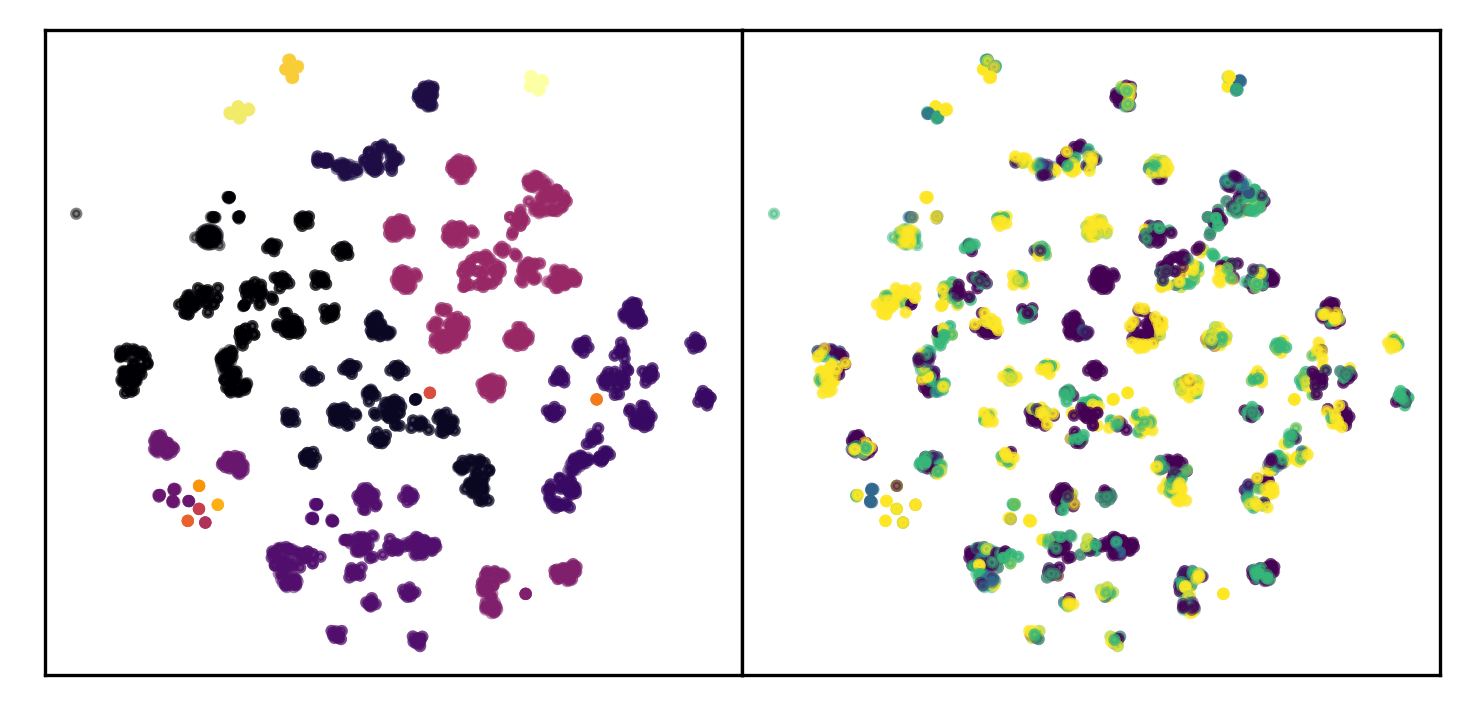

In [43]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2,figsize=(5,2.5), dpi=300)

ax[0].scatter(X_TSNE_RFP_CAT_3[:,0], X_TSNE_RFP_CAT_3[:,1], cmap='inferno', c=types_one_hot, alpha=.5, marker='.',s=15)
ax[1].scatter(X_TSNE_RFP_CAT_3[:,0], X_TSNE_RFP_CAT_3[:,1], cmap='viridis', c=yields, alpha=.5, marker='.',s=15)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
# ax[0].legend()
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('figure2tsne-catalyst.png', dpi=300, bbox_inches='tight')